In [29]:
# --- Celda 1: Importar Librerías y Cargar Datos ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset enriquecido más reciente
try:
    df = pd.read_parquet('../data/procesados/enigh_2024_final_enriquecido.parquet')
    print("Datos de 2024 cargados exitosamente.")
except FileNotFoundError:
    print("Error: No se encontró el archivo 'enigh_2024_final_enriquecido.parquet'.")
    print("Asegúrate de haber ejecutado el script de preparación de datos mejorado.")

# --- LÍNEA DE CORRECCIÓN ---
# Creamos la columna 'tiene_celular' (1 si tiene, 0 si no) a partir de la original 'celular'.
# La variable original 'celular' usa 1 para 'Sí' y 2 para 'No'.
df['tiene_celular'] = np.where(df['celular'] == 1, 1, 0)
print("Columna 'tiene_celular' creada exitosamente.")



Datos de 2024 cargados exitosamente.
Columna 'tiene_celular' creada exitosamente.


In [30]:
# --- Celda 2: Selección y Preparación de Variables para el Modelo ---

# 1. Filtrar solo los hogares en pobreza extrema
df_cluster = df[df['pobreza_e'] == 1].copy()

# 2. Seleccionar las variables (features) para el clustering
#    Ahora la columna 'tiene_celular' ya existe y el código no fallará.
features = [
    'ictpc',
    'ic_rezedu',
    'ic_asalud',
    'ic_segsoc',
    'ic_cv',
    'ic_sbv',
    'ic_ali',
    'Jefatura_Mujer',
    'rururb',
    'tiene_celular'
]

# 3. Crear el DataFrame final para el modelo, eliminando filas con datos faltantes
df_features = df_cluster[features].dropna()

print(f"\nNúmero de hogares en pobreza extrema para el clustering: {len(df_features)}")

# 4. Pre-procesamiento: Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

print("Variables listas y escaladas para el modelo K-Means.")


Número de hogares en pobreza extrema para el clustering: 4217
Variables listas y escaladas para el modelo K-Means.


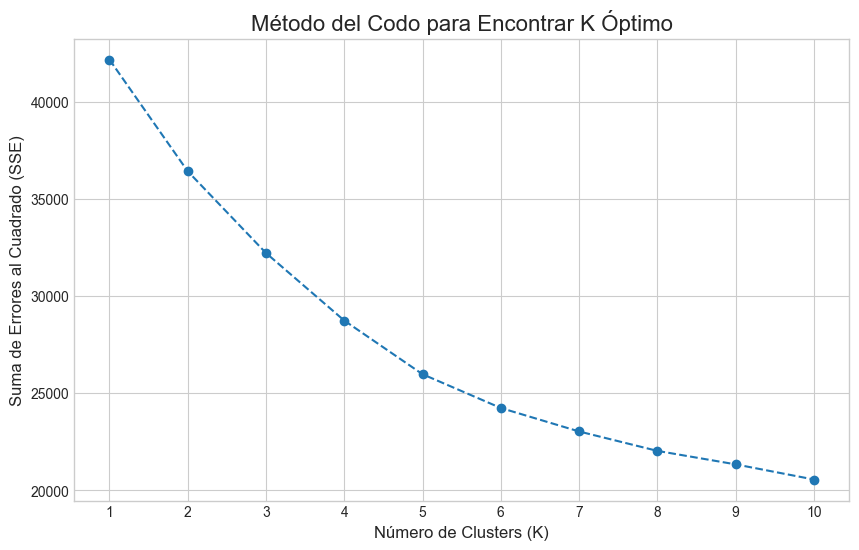

In [31]:
# Calculamos la suma de los errores al cuadrado (SSE) para diferentes valores de K
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# Graficar el resultado
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o', linestyle='--')
plt.title('Método del Codo para Encontrar K Óptimo', fontsize=16)
plt.xlabel('Número de Clusters (K)', fontsize=12)
plt.ylabel('Suma de Errores al Cuadrado (SSE)', fontsize=12)
plt.xticks(k_range)
plt.show()

In [33]:
# --- Celda 4 (MEJORADA): Aplicar K-Means y Analizar Perfiles de Forma PONDERADA ---

# Elige el valor de K basado en el gráfico del codo. Usamos 4 como ejemplo.
OPTIMAL_K = 5 # <--- ¡AJUSTA ESTE NÚMERO SEGÚN TU GRÁFICO!

# Aplicar el algoritmo
kmeans = KMeans(n_clusters=OPTIMAL_K, n_init=10, random_state=42)
# Creamos una columna con la etiqueta del cluster en nuestro dataframe de features
df_features['cluster'] = kmeans.fit_predict(X_scaled)

# --- ANÁLISIS PONDERADO DE LOS CLUSTERS ---

# 1. Unir los resultados del cluster con los datos originales para recuperar el 'factor'
df_cluster_final = df_cluster.loc[df_features.index].copy()
df_cluster_final['cluster'] = df_features['cluster']

# 2. Calcular el tamaño real (ponderado) de cada cluster
tamanio_ponderado_clusters = df_cluster_final.groupby('cluster')['factor'].sum().reset_index()
tamanio_ponderado_clusters.rename(columns={'factor': 'Numero_Hogares_Estimado'}, inplace=True)
tamanio_ponderado_clusters['Porcentaje_del_Total'] = (tamanio_ponderado_clusters['Numero_Hogares_Estimado'] / tamanio_ponderado_clusters['Numero_Hogares_Estimado'].sum()) * 100

print(f"\n--- Tamaño Ponderado de los {OPTIMAL_K} Clusters ---")
print(tamanio_ponderado_clusters.round(2))

# 3. Calcular los perfiles ponderados (media ponderada de cada variable)
def weighted_average(group, cols, weight_col):
    d = {}
    for col in cols:
        d[col] = (group[col] * group[weight_col]).sum() / group[weight_col].sum()
    return pd.Series(d)

# Aplicamos la función de promedio ponderado
cluster_profiles_ponderados = df_cluster_final.groupby('cluster').apply(weighted_average, features, 'factor')

print(f"\n--- Perfiles Ponderados de los {OPTIMAL_K} Clusters ---")
print(cluster_profiles_ponderados.round(2))


--- Tamaño Ponderado de los 5 Clusters ---
   cluster  Numero_Hogares_Estimado  Porcentaje_del_Total
0        0                   244158                 14.43
1        1                   536572                 31.70
2        2                   579292                 34.23
3        3                    50233                  2.97
4        4                   282256                 16.68

--- Perfiles Ponderados de los 5 Clusters ---
           ictpc  ic_rezedu  ic_asalud  ic_segsoc  ic_cv  ic_sbv  ic_ali  \
cluster                                                                    
0        1123.80       0.77       0.72        1.0   0.40    0.86    0.38   
1        1181.34       0.60       1.00        1.0   0.34    0.78    0.28   
2        1748.71       0.60       0.92        1.0   0.25    0.31    0.49   
3        1557.11       0.88       0.57        0.0   0.51    0.80    0.58   
4        1271.19       0.75       0.00        1.0   0.49    0.95    0.45   

         Jefatura_Mujer  rur

In [34]:
import os
# --- CÓDIGO PARA GUARDAR LOS RESULTADOS DEL CLUSTERING DE 2024 ---

# Este código asume que ya tienes los siguientes DataFrames en memoria:
# df_cluster: los datos originales de pobreza extrema de 2024
# df_features: el DataFrame que usaste para el modelo, ahora con la columna 'cluster'

# 1. Unimos la etiqueta del cluster a los datos originales para tener todas las columnas
df_cluster_final = df_cluster.loc[df_features.index].copy()
df_cluster_final['cluster'] = df_features['cluster']

# 2. Definimos la ruta y guardamos el archivo
ruta_guardado = '../data/procesados/'
if not os.path.exists(ruta_guardado):
    os.makedirs(ruta_guardado)

archivo_clusters = f'{ruta_guardado}enigh_2024_clusters_pobreza_extrema.parquet'
df_cluster_final.to_parquet(archivo_clusters)

print("¡Archivo de resultados del clustering guardado exitosamente!")
print(f"Ruta: {archivo_clusters}")

¡Archivo de resultados del clustering guardado exitosamente!
Ruta: ../data/procesados/enigh_2024_clusters_pobreza_extrema.parquet


In [35]:
import joblib

# Suponiendo que 'kmeans' es tu modelo K-Means entrenado y 'scaler' es tu StandardScaler
# Guardar el modelo
joblib.dump(kmeans, 'kmeans_model_2024.joblib')

# Guardar el escalador
joblib.dump(scaler, 'scaler_2024.joblib')

print("Modelo y escalador de 2024 guardados.")

Modelo y escalador de 2024 guardados.


In [36]:
# =======================================================================
# SCRIPT DE COMPARACIÓN DE CLUSTERS (SOBRE DATOS YA CORREGIDOS)
# =======================================================================
import pandas as pd
import numpy as np
import joblib
import plotly.express as px

# --- 1. Cargar Datos y Modelos Entrenados ---
print("Cargando modelos y datos...")
kmeans_2024 = joblib.load('kmeans_model_2024.joblib')
scaler_2024 = joblib.load('scaler_2024.joblib')

# Cargar los datos enriquecidos (ahora sabemos que contienen 'factor')
df_18 = pd.read_parquet('../data/procesados/enigh_2018_final_enriquecido.parquet')
df_24_clusters = pd.read_parquet('../data/procesados/enigh_2024_clusters_pobreza_extrema.parquet')
print("Carga completa.")

# --- 2. Preparar y Predecir sobre Datos de 2018 ---
print("\nProcesando datos de 2018...")
df_cluster_18 = df_18[df_18['pobreza_e'] == 1].copy()
if 'tiene_celular' not in df_cluster_18.columns:
    df_cluster_18['tiene_celular'] = np.where(df_cluster_18['celular'] == 1, 1, 0)

features = [
    'ictpc', 'ic_rezedu', 'ic_asalud', 'ic_segsoc', 'ic_cv', 
    'ic_sbv', 'ic_ali', 'Jefatura_Mujer', 'rururb', 'tiene_celular'
]
df_features_18 = df_cluster_18[features].dropna()
X_scaled_18 = scaler_2024.transform(df_features_18)
df_features_18['cluster'] = kmeans_2024.predict(X_scaled_18)
print("Predicción sobre datos de 2018 completada.")

# --- 3. Calcular Distribuciones PONDERADAS ---
print("\nCalculando distribuciones ponderadas...")
df_cluster_18_final = df_cluster_18.loc[df_features_18.index].copy()
df_cluster_18_final['cluster'] = df_features_18['cluster']

distribucion_18_abs = df_cluster_18_final.groupby('cluster')['factor'].sum()
distribucion_18_pct = (distribucion_18_abs / distribucion_18_abs.sum()) * 100

distribucion_24_abs = df_24_clusters.groupby('cluster')['factor'].sum()
distribucion_24_pct = (distribucion_24_abs / distribucion_24_abs.sum()) * 100

# --- 4. Crear Tabla Comparativa y Visualización ---
print("\nCreando tabla comparativa y visualización...")
perfiles = {
    0: "Aislamiento Rural Profundo", 1: "Conectividad Precaria en el Campo",
    2: "Pobreza Urbana Informal y Conectada", 3: "Formales pero Vulnerables",
    4: "Conectados con Acceso a Salud"
}
df_comparacion = pd.DataFrame({
    '2018 (%)': distribucion_18_pct, '2024 (%)': distribucion_24_pct,
    '2018 (Hogares)': distribucion_18_abs, '2024 (Hogares)': distribucion_24_abs
}).fillna(0)
df_comparacion['Perfil'] = df_comparacion.index.map(perfiles)
df_comparacion.set_index('Perfil', inplace=True)

print("\n--- Comparación Ponderada de la Estructura de Clusters (2018 vs. 2024) ---")
print(df_comparacion[['2018 (%)', '2024 (%)']].round(2))
print("\n--- (Número de Hogares Estimados) ---")
print(df_comparacion[['2018 (Hogares)', '2024 (Hogares)']].applymap('{:,.0f}'.format))

# --- 5. Visualizar la Comparación ---
print("\nGenerando visualización...")
df_grafico = df_comparacion[['2018 (%)', '2024 (%)']].reset_index().melt(
    id_vars='Perfil', value_vars=['2018 (%)', '2024 (%)'], 
    var_name='Año', value_name='Porcentaje'
)
fig = px.bar(df_grafico, x='Perfil', y='Porcentaje', color='Año', barmode='group',
             text_auto='.1f', title='Evolución de los Perfiles de Pobreza Extrema (2018 vs. 2024)',
             labels={'Porcentaje': 'Porcentaje de Hogares (%)', 'Perfil': 'Perfil del Hogar'})
fig.update_traces(textposition='outside')
fig.update_layout(xaxis_tickangle=-45) # Inclinar etiquetas para mejor lectura
fig.show()

Cargando modelos y datos...
Carga completa.

Procesando datos de 2018...
Predicción sobre datos de 2018 completada.

Calculando distribuciones ponderadas...

Creando tabla comparativa y visualización...

--- Comparación Ponderada de la Estructura de Clusters (2018 vs. 2024) ---
                                     2018 (%)  2024 (%)
Perfil                                                 
Aislamiento Rural Profundo              38.40     14.43
Conectividad Precaria en el Campo        4.86     31.70
Pobreza Urbana Informal y Conectada     16.48     34.23
Formales pero Vulnerables                2.27      2.97
Conectados con Acceso a Salud           37.98     16.68

--- (Número de Hogares Estimados) ---
                                    2018 (Hogares) 2024 (Hogares)
Perfil                                                           
Aislamiento Rural Profundo                 874,340        244,158
Conectividad Precaria en el Campo          110,642        536,572
Pobreza Urbana Informal y 

/Users/omartellez/proyecto_celular_pobreza/env/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning:

urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020

